In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from __future__ import unicode_literals
from IPython.core.display import display, HTML
import glob
from radical.entk import Profiler
import radical.analytics as ra
import radical.utils as ru
import radical.pilot as rp
import numpy as np
import math


pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

%matplotlib inline

/Users/JumanaDakka/environments/venv/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:63: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Generate task uids

def get_task_uids(num_pipelines):
    
    num_tasks = num_pipelines*4*1
    task_uids = []
    for t in range(num_tasks):
        task_uids.append('radical.entk.task.%04d'%t)

    return task_uids

In [3]:

# Get information from all the entk profiles

def get_entk_info(pipelines):
    
    p = Profiler(src = './null_workload_{0}_replicas_trial_1'.format(pipelines))
    
    task_uids = get_task_uids(pipelines)
    
    entk_dur = p.duration(task_uids, states=['SCHEDULING','DONE'])
    
    # Time taken in appmanager to rreq function call
    entk_core_1 = p.duration('radical.entk.appmanager.0000', events=['create amgr obj', 'init rreq submission'])
    
    # Time taken to tear down appmanager
    entk_core_2 = p.duration('radical.entk.appmanager.0000', events=['start termination', 'termination done'])
    
    # Time taken to create resource manager obj
    entk_core_3 = p.duration('radical.entk.resource_manager.0000', events = ['create rmgr obj', 'rmgr obj created'])
    
    # Time taken to create and submit resource reservation
    entk_core_4 = p.duration('radical.entk.resource_manager.0000', events = ['creating rreq', 'rreq submitted'])
    
    # Time taken to deallocate resource reservation
    entk_core_5 = p.duration('radical.entk.resource_manager.0000', events = ['canceling resource allocation', 'resource allocation cancelled'])
    
    entk_core_dur = entk_core_1 + entk_core_2 + entk_core_3 
    
    #entk_total_dur = entk_dur_1 + entk_dur_2 + entk_core_dur
    
    return entk_dur

In [4]:
# Get information from all the rp profile files and json file
# returns 0,0 if no rp files are found

def get_rp_info(pipeline):

    rp_folder = glob.glob('./null_workload_{0}_replicas_trial_1/rp.*'.format(pipeline))
    src = rp_folder[0]
    session = ra.Session(stype='radical.pilot', src=src)
    units = session.filter(etype='unit', inplace=False)
    pilots = session.filter(etype='pilot', inplace=False)
    exec_dur = units.duration([rp.AGENT_EXECUTING, rp.AGENT_STAGING_OUTPUT_PENDING])
    rp_dur = units.duration([rp.UMGR_SCHEDULING_PENDING, rp.DONE])
    task_exec_dur = []

    get_units = session.get(etype='unit')
    assert len(get_units) == pipelines*4

    sorted_units = sorted(units.list('uid'))
    # print sorted_units

    for x in range(0, pipeline*4, pipeline):
    #   print x
    #   print x + pipeline
    #   print sorted_units[x:x+pipeline]
        session = ra.Session(stype='radical.pilot', src=src)
        subset_units = session.filter(uid=sorted_units[x:x+pipeline])
        exec_dur = subset_units.duration([rp.AGENT_EXECUTING, rp.AGENT_STAGING_OUTPUT_PENDING])
        task_exec_dur.append(exec_dur)
    
    return rp_dur, task_exec_dur
    


In [7]:
data_df = pd.DataFrame(columns=['EnTK overhead', 
                           'RP overhead', 
                           'Execution duration'])
err_df = pd.DataFrame(columns=['EnTK overhead', 
                           'RP overhead', 
                           'Execution duration'])
stages_df = pd.DataFrame(columns=['Stage 1', 
                                  'Stage 2', 
                                  'Stage 3', 
                                  'Stage 4']) 
stages_err_df = pd.DataFrame(columns=['Stage 1', 
                                  'Stage 2', 
                                  'Stage 3', 
                                  'Stage 4']) 
pipelines_list = [8, 16, 32, 64, 128]
trials = 1

for pipelines in pipelines_list:
    entk_dur = get_entk_info(pipelines)
    rp_dur, task_exec_dur = get_rp_info(pipelines)

    print entk_dur, rp_dur, task_exec_dur, sum(task_exec_dur)

    data_df.loc[pipelines] = [entk_dur - rp_dur, rp_dur - sum(task_exec_dur) , task_exec_dur]
    stages_df.loc[pipelines] = task_exec_dur

'''
for pipelines in pipelines_list:
    
    entk_ov_list = list()
    rp_ov_list   = list()
    exec_list    = list()
    
    for t in range(1,trials+1):
        entk_dur = get_entk_info(pipelines,t)
        rp_dur, task_exec_dur = get_rp_info(pipelines,t)

        #print entk_dur, rp_dur, task_exec_dur
        
        temp_entk_dur = entk_dur - rp_dur
        temp_rp_dur   = rp_dur - sum(task_exec_dur)
        temp_exec_dur = task_exec_dur
        #df.loc[pipelines] = [entk_dur - rp_dur, rp_dur - task_exec_dur , task_exec_dur]
        #df_stages.loc[pipelines] = task_exec_dur
        
        entk_ov_list.append(temp_entk_dur)
        rp_ov_list.append(temp_rp_dur)
        exec_list.append(temp_exec_dur)
        
    exec_list_av = np.mean(exec_list, axis=0)
    exec_list_av = exec_list_av.tolist()
    
    data_df.loc[pipelines] = [np.average(entk_ov_list),
                              np.average(rp_ov_list),
                              exec_list]
    
    err_df.loc[pipelines] = [np.std(entk_ov_list)/math.sqrt(trials),
                             np.std(rp_ov_list)/math.sqrt(trials),
                             np.std(exec_list_av, axis=0)/math.sqrt(trials)]
    
    
    stages_df.loc[pipelines] = exec_list_av
    stages_err_df.loc[pipelines] = np.std(exec_list, axis=0)/math.sqrt(trials)
#data_df['RP overhead']
stages_df
'''

32.0792000294 30.6115000248 [3.27590012550354, 4.9944000244140625, 6.011399984359741, 6.078200101852417] 20.3599002361
30.7898001671 29.3840999603 [4.392300128936768, 6.307600021362305, 6.625100135803223, 6.098199844360352] 23.4232001305
61.5842001438 60.0558998585 [15.476500034332275, 8.355600118637085, 18.205100059509277, 12.330000162124634] 54.3672003746
93.8217999935 91.6716001034 [28.40059995651245, 25.573099851608276, 26.47760009765625, 22.85920000076294] 103.310499907
109.402999878 108.015100002 [34.7046000957489, 47.432899951934814, 50.20359992980957, 38.00970005989075] 170.350800037


u"\nfor pipelines in pipelines_list:\n    \n    entk_ov_list = list()\n    rp_ov_list   = list()\n    exec_list    = list()\n    \n    for t in range(1,trials+1):\n        entk_dur = get_entk_info(pipelines,t)\n        rp_dur, task_exec_dur = get_rp_info(pipelines,t)\n\n        #print entk_dur, rp_dur, task_exec_dur\n        \n        temp_entk_dur = entk_dur - rp_dur\n        temp_rp_dur   = rp_dur - sum(task_exec_dur)\n        temp_exec_dur = task_exec_dur\n        #df.loc[pipelines] = [entk_dur - rp_dur, rp_dur - task_exec_dur , task_exec_dur]\n        #df_stages.loc[pipelines] = task_exec_dur\n        \n        entk_ov_list.append(temp_entk_dur)\n        rp_ov_list.append(temp_rp_dur)\n        exec_list.append(temp_exec_dur)\n        \n    exec_list_av = np.mean(exec_list, axis=0)\n    exec_list_av = exec_list_av.tolist()\n    \n    data_df.loc[pipelines] = [np.average(entk_ov_list),\n                              np.average(rp_ov_list),\n                              exec_list]\n 

In [8]:
%matplotlib inline

In [9]:
data_df

,EnTK overhead,RP overhead,Execution duration
8,1.4677,10.251600,"[3.2759001255, 4.99440002441, 6.01139998436, 6..."
16,1.4057,5.960900,"[4.39230012894, 6.30760002136, 6.6251001358, 6..."
32,1.5283,5.688699,"[15.4765000343, 8.35560011864, 18.2051000595, ..."
64,2.1502,-11.638900,"[28.4005999565, 25.5730998516, 26.4776000977, ..."
128,1.3879,-62.335700,"[34.7046000957, 47.4328999519, 50.2035999298, ..."


In [7]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-colorblind')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 1
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot(111)    
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

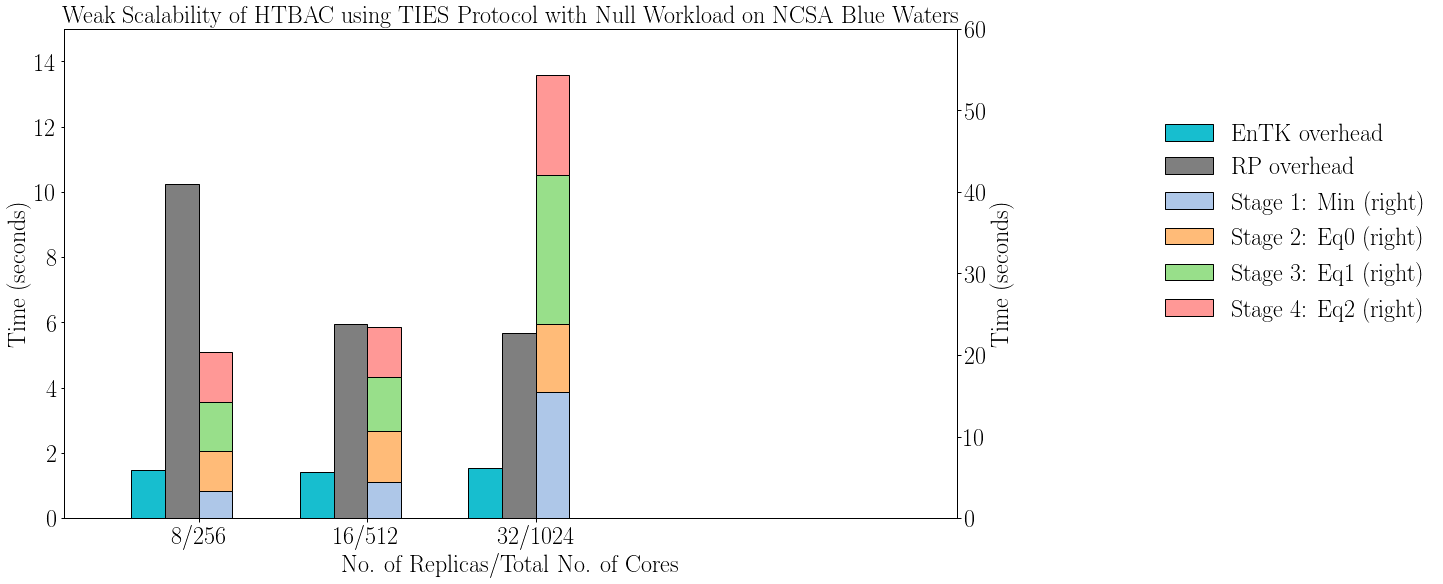

In [10]:
fig, ax = fig_setup()
width=.2
#ov_err = err_df
#exec_err = stages_err_df

ax = data_df.plot(kind='bar', 
             ax=ax,
             y=data_df.columns.drop('Execution duration').tolist(),
             fontsize=SIZE,
             #yerr=ov_err,
             width=2*width,
             position=1,
             color = [tableau20[(16)], tableau20[(20)]],
             title='Weak Scalability of HTBAC using TIES Protocol with Null Workload on NCSA Blue Waters',
             legend=False)


ax2 = stages_df.plot(ax=ax, 
                     stacked=True, 
                     #yerr=exec_err,
                     secondary_y=True, 
                     color=   [tableau20[(1)], 
                              tableau20[(3)], 
                              tableau20[(5)], 
                              tableau20[(7)]],
                     width=width, legend=False, position=0, kind = 'bar')
ax2.set_ylim(0,60)
ax.set_ylim(0,15)
ax.set_xlabel('No. of Replicas/Total No. of Cores', fontsize=SIZE)
ax.set_xticklabels(['8/256','16/512', '32/1024'])            
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

ax.set_ylabel('Time (seconds)', fontsize=SIZE)
ax2.set_ylabel('Time (seconds)', fontsize=SIZE)
ax.set_title(ax.get_title(), fontsize=SIZE)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
labels = l1 
#for i in range(7): labels += [l2[i] + ' execution time (right)']
    
labels += [l2[0] + ': Min (right)']
labels += [l2[1] + ': Eq0 (right)']
labels += [l2[2] + ': Eq1 (right)']
labels += [l2[3] + ': Eq2 (right)']

handles = h1 + h2
plt.legend(handles,labels,fontsize=SIZE, bbox_to_anchor = (1.55,.85))
plt.gca().set_xlim([-.8,4.5])
plt.show()
fig.savefig('null_workload_ties.png', dpi=100, bbox_inches='tight')
fig.savefig('null_workload_ties.pdf', dpi=100, bbox_inches='tight')